# Business license cleanup

This notebook what we need to do to clean the business license data from the [Vancouver Open Data Portal](https://opendata.vancouver.ca) so we can analyze business survival/failure and build a model to predict the likelihood of a new business surviving.

TODO:

- Drop `Status == 'Cancelled'` and figure out what to do with `Status in ['Pending', 'Inactive']`
- Drop `BusinessType in ['Exhibitions/Shows/Concerts', 'Temp Liquor Licence Amendment']` and any other one-off / temporary business categories
- Drop `Live-aboards` type as well as they are basically all duplicated.
- Figure out how to account for business that have shuttered, but did not inform the city (probably something like if a business is there one year, gone the next, assume it's out of business)

Extension ideas:

* incorporate property tax data

The first thing we will do[^1] is load our data and take a cursory look at what's in it:

[^1] When I say first thing, what I really mean is *first thing in this blog post*. I did a fair amount of random poking around just to figure out what cleaning needed to be done.

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/2020.11.15-business-licences.csv', sep=';')
df.info()

/Users/colinspear/.venv/business_licenses/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509444 entries, 0 to 509443
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   FOLDERYEAR             509444 non-null  int64  
 1   LicenceRSN             509444 non-null  int64  
 2   LicenceNumber          509444 non-null  object 
 3   LicenceRevisionNumber  509444 non-null  int64  
 4   BusinessName           493514 non-null  object 
 5   BusinessTradeName      207726 non-null  object 
 6   Status                 509444 non-null  object 
 7   IssuedDate             424090 non-null  object 
 8   ExpiredDate            423765 non-null  object 
 9   BusinessType           509444 non-null  object 
 10  BusinessSubType        277373 non-null  object 
 11  Unit                   136789 non-null  object 
 12  UnitType               136748 non-null  object 
 13  House                  286350 non-null  object 
 14  Street                 286363 non-nu

So we've got 24 columns and about 500k observations. We have information about when a business licence was issued, it's status, when it expired, it's location, size, type. Looks fairly promising so far.

## Identify businesses through time

According to the [documentation](https://opendata.vancouver.ca/explore/dataset/business-licences/information/?disjunctive.status&disjunctive.businesssubtype), `LicenceRSN` is the *unique identifier for each business licence generated by the system*. 

As someone who came to this project knowing nothing about how the Vancouver Business Licencing process works, I assumed that a when a business renewed its licencse (this must happen yearly), it would retain the same license number which would simply get updated. This would have been great, because then we could have just used `LicenceRSN` to identify our business. 

As it turns out, each time a business renews their license, they get a brand new `LicenceRSN`. Ideally we would have a `BusinessID` column that would give us a unique identifier for each business. Unfortunately that's not the case, so we are going to have to make some (hopefully reasonable) assumptions and make one for ourselves. `BusinessName` seems like a good place to start.

In [2]:
df = df.loc[df['Province']=='BC']
df = df.loc[df['BusinessName'].notnull()]

In [3]:
df.shape

(490815, 24)

In [4]:
id_cols = ['BusinessName', 'BusinessTradeName', 'BusinessType', 'BusinessSubType']

for col in id_cols + ['House', 'Street', 'City', 'PostalCode', 'LocalArea']:
    df[col] = df[col].replace(np.nan, '')
    df[col] = df[col].replace('NaN', '')

In [5]:
# df['BusinessName'].replace(np.nan, -1)
df['name_id'] = df.groupby(id_cols).ngroup()
df['name_year_id'] = df.groupby(id_cols + ['FOLDERYEAR']).ngroup()
df['name_code_id'] = df.groupby(id_cols + ['PostalCode']).ngroup()
df['name_code_year_id'] = df.groupby(id_cols + ['FOLDERYEAR', 'PostalCode']).ngroup()
df['name_address_id'] = df.groupby(id_cols + ['House', 'Street', 'City', 'PostalCode', 'LocalArea']).ngroup()
df['name_address_year_id'] = df.groupby(id_cols + ['FOLDERYEAR', 'House', 'Street', 'City', 'PostalCode', 'LocalArea']).ngroup()
# df['id'] = df['id'].replace(-1, np.nan)

In [6]:
# for var in ['name_year_id', 'name_code_year_id', 'name_address_year_id']:
#     print(len(df[var].unique()))

for var in ['name_id', 'name_code_id', 'name_address_id', 'name_year_id',  'name_code_year_id',  'name_address_year_id']:
    print(f'Unique rows, {var}: ', len(df[var].unique()))


Unique rows, name_id:  105776
Unique rows, name_code_id:  114492
Unique rows, name_address_id:  161396
Unique rows, name_year_id:  461196
Unique rows, name_code_year_id:  477565
Unique rows, name_address_year_id:  483174


As we add more columns to our identification, we get more unique values (naturally). On the one hand this is good because we get to keep more data for our analysis, on the other hand we will end up misidentifying a business that changed address as a unique business. I am going to choose to go with the id that gives us the most unique values (`name_address_id`), then work backward to find any businesses that changed address.

Even with the most detailed id, there are almost 30,000 licences that are not unique by year. We'll take a look at these to see if we can do anything about this. We'll be able to save some of these with the `LicenceRevisionNumber` column, but we will undoubtedly have to throw some out that we just aren't able to distinguish.

As with any analysis, there is always a trade-off between time and perfection. There are a lot of ways people refer to this (analysis paralysis, 80-20 rule, etc.) and it is an ever-present menace. There will always be little rabbit holes to go down, curiosities, inexplicable cases that "maybe if I just dig a little deeper, I can explain!!!". It's up to you as the analyst (or me in this case) to decide what is a good use of your time. **This. Is. Hard.** Always. Personally I have the attention span of a two year old, so I am always having to drag myself back to ask myself if what I am doing is likely to have a material impact on the analysis or if I am simply chasing something shiny. 

With that in mind, I am going to restrict myself to 1) finding address change cases and 2) finding licence revisions for uniquely identified companies. I'm sure there will still be duplicates after this. If I want to be super careful, I can compare features (`Status`, `NumberofEmployees`, etc.) of the licences I am throwing out to the licences I am keeping to see if they differ in any substantial way. Let's start with 2).

In [7]:
df['id'] = df['name_address_id']
df['year_id'] = df['name_address_year_id']

df = df.drop(['name_id', 'name_year_id', 'name_code_id', 'name_code_year_id', 'name_address_id', 'name_address_year_id'], axis=1)

In [8]:
print(len(df['id'].unique()))
print(len(df['year_id'].unique()))

161396
483174


In [9]:
year_duplicates = df.loc[df['year_id'].duplicated(keep=False)]

# year_duplicates.sort_values(['id', 'FOLDERYEAR', 'LicenceRevisionNumber'])[:10].to_markdown()

In [10]:
year_duplicates.shape

(12652, 26)

In [11]:
year_duplicates.shape[0] - len(year_duplicates['year_id'].unique())

7641

So I see both licence revisions as well as other cases. Let's just look at the licence revisions.

In [12]:
lic_revisions = year_duplicates.loc[~year_duplicates.duplicated(subset=['year_id', 'LicenceRevisionNumber'], keep=False)]

# lic_revisions.sort_values(['id', 'FOLDERYEAR', 'LicenceRevisionNumber'])[:10]

This looks pretty good! All of these went from an initial status of `Inactive` to `Issued`. My guess is that these are folks who didn't submit their renewal application by the end of the year so their licence lapsed (the [documentation](https://opendata.vancouver.ca/explore/dataset/business-licences/information/?disjunctive.status&disjunctive.businesssubtype) defines `Inactive` as *Licence is no longer active*). As it turns out, close to 90% of these licences take on one of these values. So what do the others look like?

In [13]:
lic_revisions['max_rev'] = lic_revisions.groupby('year_id')['LicenceRevisionNumber'].transform('max')

lic_revisions.loc[lic_revisions['max_rev']>1].sort_values(['id', 'FOLDERYEAR', 'LicenceRevisionNumber'])[:10]

<ipython-input-13-521ea80921b0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_revisions['max_rev'] = lic_revisions.groupby('year_id')['LicenceRevisionNumber'].transform('max')


,FOLDERYEAR,LicenceRSN,LicenceNumber,LicenceRevisionNumber,BusinessName,BusinessTradeName,Status,IssuedDate,ExpiredDate,BusinessType,...,Country,PostalCode,LocalArea,NumberofEmployees,FeePaid,ExtractDate,Geom,id,year_id,max_rev
47682,16,2694059,16-134320,1,(Alexei Selivanov),RCTC Travel Visa Services,Inactive,NaN,NaN,Office,...,CA,V5Z 0E9,Fairview,2.0,22.0,2019-07-21T13:49:21-07:00,"{""type"": ""Point"", ""coordinates"": [-123.1165554...",520,1652,2
47875,16,2706327,16-134320,2,(Alexei Selivanov),RCTC Travel Visa Services,Issued,2016-05-17T16:03:40-07:00,2016-12-31,Office,...,CA,V5Z 0E9,Fairview,2.0,22.0,2019-07-21T13:49:21-07:00,"{""type"": ""Point"", ""coordinates"": [-123.1165554...",520,1652,2
123890,16,2746968,16-135410,1,(Christopher Ghirardi),,Cancelled,NaN,NaN,Office,...,CA,V5Y 1P4,Mount Pleasant,1.0,22.0,2019-07-21T13:49:21-07:00,"{""type"": ""Point"", ""coordinates"": [-123.1071065...",3518,11533,2
14731,16,2756326,16-135410,2,(Christopher Ghirardi),,Issued,2016-09-07T10:15:39-07:00,2016-12-31,Office,...,CA,V5Y 1P4,Mount Pleasant,1.0,NaN,2019-07-21T13:49:21-07:00,"{""type"": ""Point"", ""coordinates"": [-123.1071065...",3518,11533,2
100717,13,1821962,13-202543,0,(Cui-Fen Ye),Unicorn Textiles Co,Inactive,2013-01-02T22:40:41-08:00,2013-12-31,Wholesale Dealer,...,CA,,Renfrew-Collingwood,0.0,129.0,2019-07-21T13:49:09-07:00,NaN,3934,12835,2
125340,13,2099052,13-202543,2,(Cui-Fen Ye),Unicorn Textiles Co,Issued,2013-10-03T15:04:44-07:00,2013-12-31,Wholesale Dealer,...,CA,,Renfrew-Collingwood,0.0,10.0,2019-07-21T13:49:09-07:00,NaN,3934,12835,2
457737,20,3653063,20-103885,1,(Donna Markin),Markin Design Management,Inactive,2020-09-03T07:37:23-07:00,2020-12-31,Office,...,CA,,Kitsilano,1.0,25.0,2020-11-15T00:09:33-08:00,NaN,5179,16998,2
463116,20,3655672,20-103885,2,(Donna Markin),Markin Design Management,Issued,2020-09-08T16:08:47-07:00,2020-12-31,Office,...,CA,,Kitsilano,1.0,10.0,2020-11-15T00:09:33-08:00,NaN,5179,16998,2
105456,15,2365114,15-135393,0,(Jan Pazhouh),Urban Mobility,Inactive,2015-01-07T13:42:57-08:00,2015-12-31,Office,...,CA,,Downtown,0.0,133.0,2019-07-21T13:49:16-07:00,NaN,8872,29134,2
279942,15,2518570,15-135393,2,(Jan Pazhouh),Urban Mobility,Issued,2015-07-24T16:09:27-07:00,2015-12-31,Office,...,CA,,Downtown,0.0,10.0,2019-07-21T13:49:17-07:00,NaN,8872,29134,2


Hmm. Strange. `LicenceRevisionNumber` doesn't always start with `0` and seems to sometimes skip values. However, it still looks like the highest `LicenceRevisionNumber` is the most recent license status. If I look at all the observations for a particular business it looks like this isn't unusual - lots of transitions from `Inactive` to `Issued`[^2]. What happens if we just take the latest lecence revision for each company?

[^2] I also noticed after rereading the documentation of Status and poking around the city's business licence website that a status of `Cancelled` most likely means a cancelled application. I don't think these will be relevant for us, so they will need to be dropped at some point. Also, as far as going out of business goes, the city says this: 

> Please tell us if you close your business. It helps us keep our records up-to-date so we don't send you licence renewal notices in the future.

I seriously doubt that everybody does the city this courtesy, so we will have to look for businesses that drop out of the data from one year to the next.

In [14]:
lic_revisions.loc[lic_revisions['LicenceRevisionNumber']==lic_revisions['max_rev'], 'Status'].value_counts()

Issued                  1199
Pending                  148
Cancelled                 95
Inactive                  37
Gone Out of Business      17
Name: Status, dtype: int64

Looks pretty good. I'm going to go ahead and go with this. I will have to figure out what to do with the `Pending` and `Inactive` cases, but that will apply to the rest of the data as well, so I will do that all together. Now to see about the year duplicates that are not because of licence revisions.[^3]

[^3] Full disclosure, after making the `other_duplicates` dataframe below, I had a quick look at the data, grabbing some random chunks of rows just to see what they looked like. That led to the following *Major Discovery*.

In [15]:
lic_revisions_final = lic_revisions.loc[lic_revisions['LicenceRevisionNumber']==lic_revisions['max_rev']]

In [16]:
# other_duplicates.shape

# drop_cols = ['LicenceRSN', 'LicenceRevisionNumber', 'BusinessTradeName', 'BusinessSubType', 'Unit', 'UnitType']
# df.loc[df['id'].isin(other_duplicates['id']) & (df['BusinessType']=='One-Family Dwelling')].drop(drop_cols, axis=1).sort_values(['id', 'FOLDERYEAR'])[200:220]

In [17]:
other_duplicates = year_duplicates.loc[year_duplicates.duplicated(subset=['year_id', 'LicenceRevisionNumber'], keep=False)]

df1 = pd.concat([other_duplicates['BusinessType'].value_counts(), 
           other_duplicates['BusinessType'].value_counts() / other_duplicates.shape[0]
          ], axis=1)[:10]
df1.columns = ['BusinessCount', 'ShareofTotal']
df1 = df1.join(
    pd.concat([df['BusinessType'].value_counts(), 
               df['BusinessType'].value_counts() / df.shape[0]], 
              axis=1)
)

df1.columns = ['BusinessCount_dup', 'ShareofTotal_dup', 'BusinessCount_full', 'ShareofTotal_full']

df1.to_markdown()

'|                               |   BusinessCount_dup |   ShareofTotal_dup |   BusinessCount_full |   ShareofTotal_full |\n|:------------------------------|--------------------:|-------------------:|---------------------:|--------------------:|\n| One-Family Dwelling           |                3144 |          0.324995  |                24711 |          0.0503469  |\n| Apartment House Strata        |                 938 |          0.0969609 |                13905 |          0.0283304  |\n| Multiple Dwelling             |                 859 |          0.0887947 |                 8812 |          0.0179538  |\n| Live-aboards                  |                 726 |          0.0750465 |                  730 |          0.00148732 |\n| Duplex                        |                 582 |          0.0601613 |                 7186 |          0.014641   |\n| Exhibitions/Shows/Concerts    |                 466 |          0.0481704 |                 1164 |          0.00237157 |\n| Temp Liquor L

Owning a rental property is overrepresented in the duplicated data (about 12% of the total), especially a one-family dwelling. This makes sense as pretty much all of these do not have any location information, presumably due to privacy concerns:

> BusinessType
>
> Description of the business activity, usually in accordance with the definition in the Licence By-Law No. 4450. Note: Business type names that have a notation of *Historic* at the end signify retired business licence types. These are business licence types that were once active but have since been retired. **Due to privacy concern, some business types do not have address data.**

So any person (business) who owns and rents out more than one property in the same year will be duplicated. I wasn't able to find confirmation that a licence is required for *every* rental property[^3], but based on what I can see here it seems likely. A quick email to the City would probably be able to confirm.

[^3] After five minutes of searching :D... 80-20 rule, etc...

Now we have a choice. Are these duplicates important to save? Can we just throw them out? Whatever we decide to do, it's important to think about the implications of the decision from both a technical and business perspective. How does our decision impact our data and further downstream, our modeling? What are our business goals and how does our decision impact these?

To help guide the decision, I would think about what our ultimate goal (who our ultimate end user) is. In this case, I would like to have a simple tool that someone who is thinking of starting a business can use to give them some idea of how previous businesses with similar characteristics fared. How likely is it, given some basic characteristics, that my taqueria in Yaletown will survive?

If I am someone who already a number of rental properties, I already probably have a pretty good idea of the market. It's unlikely that my lowly machine learning model is going to add a tremendous amount of value. As the data scientist building this model, I also care more about providing insight to folks who have the least amount of information to begin with. That's a personal preference (or a business decision if I were doing this for an employer or a client) rather than a technical decision.

From a technical perspective, we are likely introducing some bias. If we throw out the duplicates we will almost certainly be introducing some bias into our model: it's unlikely that the survival rate of a one property rental company (the ones we will be saving) will be the same as that of a multiple property rental company (who we will be throwing out). 

For the sake of time (and actually getting to the model-building part of this project), I am going to throw out the duplicates. If we need to, we can always come back and revisit these samples. It will be more important to try and identify the companies that have gone out of business and *not* notified the City. This is what I will turn my attention to now.

In [18]:
# drop the initial subset of data and add back in the licencse revisions

df = df.loc[~df['year_id'].isin(year_duplicates['year_id'])]
df = df.append(lic_revisions_final.drop('max_rev', axis=1), verify_integrity=True)


In [19]:
# drop businesses that don't appear in more than one year
df['max_year'] = df.groupby('id')['FOLDERYEAR'].transform('max')
df['min_year'] = df.groupby('id')['FOLDERYEAR'].transform('min')
df['years_active'] = df['FOLDERYEAR'] - df['min_year']
df['lifespan'] = df['max_year'] - df['min_year']
# drops all businesses without records before 2020
df = df.loc[~((df['lifespan']==0) & (df['FOLDERYEAR']==df['FOLDERYEAR'].max()))]

In [20]:
df.columns

Index(['FOLDERYEAR', 'LicenceRSN', 'LicenceNumber', 'LicenceRevisionNumber',
       'BusinessName', 'BusinessTradeName', 'Status', 'IssuedDate',
       'ExpiredDate', 'BusinessType', 'BusinessSubType', 'Unit', 'UnitType',
       'House', 'Street', 'City', 'Province', 'Country', 'PostalCode',
       'LocalArea', 'NumberofEmployees', 'FeePaid', 'ExtractDate', 'Geom',
       'id', 'year_id', 'max_year', 'min_year', 'years_active', 'lifespan'],
      dtype='object')

### Cleanup `Status` and calculate lifespan of business

It's worth noting here that I am dropping all businesses established in the latest year. Since we are building a model to predict business survival, these aren't very useful to us as they haven't been around long enough to tell us anything[^4]. At some point we will have to define what it means to survive, but for now I will just keep track of how long a business has been around and worry about what survival means during analysis.

I had originally planned on also dropping businesses that never took on an `Issued` status. I had a look at them (see commented code below) and most of them show a value of `Pending` for one or more years before switching to `Gone Out of Business`. It's hard to know exactly what is going on with these. It could be an error or it could be that these businesses never finished their application, paid their fees, or didn't get their application approved for some other reason. Either way, it seems they were mostly operating so I think I will keep them in the data and assume they were operating until the final year they appear.

Now let's ID the businesses that went out of business but never notified the city.

[^4] There is plenty of interesting analysis that you could do with these, including looking at the effect of Covid 19 on business creation, something that I would very much like to do at some point. But for now, prediction.

In [21]:
'''
never_issued = df.groupby('id')['Status'].apply(lambda x: 'Issued' not in x.unique())

# never_issued.name = 'never_issued'
never_issued = never_issued[never_issued==True].index

df.loc[
    (df['id'].isin(never_issued)), 
    disp_cols+['IssuedDate']
].sort_values(['id', 'FOLDERYEAR'])[200:250]
'''

"\nnever_issued = df.groupby('id')['Status'].apply(lambda x: 'Issued' not in x.unique())\n\n# never_issued.name = 'never_issued'\nnever_issued = never_issued[never_issued==True].index\n\ndf.loc[\n    (df['id'].isin(never_issued)), \n    disp_cols+['IssuedDate']\n].sort_values(['id', 'FOLDERYEAR'])[200:250]\n"

In [22]:
# businesses that drop out of data without ever recording a value of Gone Out of Business
df['new_status'] = df['Status']

c = ((df['max_year']==df['FOLDERYEAR']) & (df['FOLDERYEAR']!=20))
df.loc[c, 'new_status'] = 'GOB'

df.groupby('FOLDERYEAR')['new_status'].value_counts().unstack(level=0)

FOLDERYEAR,13,14,15,16,17,18,19,20
new_status,,,,,,,,
Cancelled,119.0,66.0,107.0,102.0,90.0,91.0,51.0,2359.0
GOB,11452.0,12153.0,11565.0,13237.0,12487.0,17040.0,21326.0,NaN
Gone Out of Business,173.0,206.0,206.0,256.0,75.0,88.0,220.0,3080.0
Inactive,63.0,79.0,98.0,96.0,121.0,76.0,77.0,859.0
Issued,44120.0,42106.0,42872.0,43102.0,41895.0,38825.0,36265.0,40412.0
Pending,3099.0,4345.0,4320.0,2616.0,3604.0,4604.0,4582.0,4678.0


Not surprisingly, most businesses that don't survive don't bother letting the city know. Now there shouldn't be any `Gone Out of Business` values left in the data, but there clearly are. Let's see if we can figure out why.

In [23]:
anomalies = df.loc[(df['new_status']=='Gone Out of Business') & (df['FOLDERYEAR']!=20), 'id'].unique()

disp_cols = ['FOLDERYEAR', 'BusinessName', 'BusinessType', 'Status', 'id', 'year_id', 'max_year', 'min_year']

anomalies = df.loc[df['id'].isin(anomalies), disp_cols].sort_values(['id', 'FOLDERYEAR'])

anomalies[40:60]

# anomalies.groupby('BusinessType')['id'].nunique().sort_values(ascending=False)


,FOLDERYEAR,BusinessName,BusinessType,Status,id,year_id,max_year,min_year
96963,15,(Allison Dube),Apartment House Strata,Issued,684,2189,20,14
277245,16,(Allison Dube),Apartment House Strata,Issued,684,2191,20,14
305151,18,(Allison Dube),Apartment House Strata,Gone Out of Business,684,2194,20,14
482375,19,(Allison Dube),Apartment House Strata,Issued,684,2195,20,14
488725,20,(Allison Dube),Apartment House Strata,Issued,684,2196,20,14
195675,14,(Aman Webeshet),Auto Detailing,Issued,731,2356,17,14
71312,15,(Aman Webeshet),Auto Detailing,Issued,731,2357,17,14
210952,16,(Aman Webeshet),Auto Detailing,Gone Out of Business,731,2358,17,14
303568,17,(Aman Webeshet),Auto Detailing,Gone Out of Business,731,2359,17,14
297951,13,(Anastasia Pantazis),Duplex,Issued,918,2889,17,13


This is strange. It looks like a lot of these have gone in and out of business more than once under the same name. Most of them are contractors or other businesses that are likely owned and operated by a single person. I'm not really sure what I can do with these, so I will leave them out for now. There are about 1200 businesses and 5500 rows that will be dropped. The rest of these all appear in more than one year. I am going to count anything that is in the data without a `Gone Out of Business` status as operational. 

In [24]:
anomalies.loc[df['FOLDERYEAR']==df['max_year'], 'BusinessType'].value_counts()[:10]

Contractor                        204
Office                            104
Electrical Contractor              87
Retail Dealer                      85
Restaurant Class 1                 58
Ltd Service Food Establishment     57
Contractor - Special Trades        49
One-Family Dwelling                31
Secondary Suite - Permanent        28
Health Services                    28
Name: BusinessType, dtype: int64

In [25]:
df = df.loc[~df['id'].isin(anomalies['id'])]

Since I didn't reclassify the status of any businesses in 2020, we still need to do some cleanup there as well. Let's see what statuses we have. 

In [26]:
df.loc[df['FOLDERYEAR']==20, 'new_status'].value_counts()

Issued                  40159
Pending                  4595
Gone Out of Business     3036
Cancelled                2143
Inactive                  851
Name: new_status, dtype: int64

`Issued` and `Gone Out of Business` are pretty straight forward. `Pending` I will go ahead and give them the benefit of the doubt and say they are still in business (remember these are all businesses that were established before 2020, so it's possible their paperwork just hasn't gone through). So what do we do with the `Cancelled` and `Inactive` ones? Well let's have a look at these.

In [27]:
df.loc[
    df['id'].isin(df.loc[(df['FOLDERYEAR']==20) & (df['Status']=='Inactive'), 'id']),
    disp_cols
].sort_values(['id', 'FOLDERYEAR'])[200:220]

,FOLDERYEAR,BusinessName,BusinessType,Status,id,year_id,max_year,min_year
333275,19,(Martin Staffolani),Referral Services,Issued,13572,44306,20,19
472976,20,(Martin Staffolani),Referral Services,Inactive,13572,44307,20,19
183710,15,(Martin Voslar),Instruction,Issued,13576,44327,20,15
83885,16,(Martin Voslar),Instruction,Issued,13576,44328,20,15
100447,17,(Martin Voslar),Instruction,Issued,13576,44329,20,15
341616,18,(Martin Voslar),Instruction,Issued,13576,44330,20,15
321646,19,(Martin Voslar),Instruction,Issued,13576,44331,20,15
496557,20,(Martin Voslar),Instruction,Inactive,13576,44332,20,15
126259,17,(Maryam Zagar),Office,Issued,13642,44557,20,17
421833,18,(Maryam Zagar),Office,Issued,13642,44558,20,17


A quick look makes it seem that a lot of long standing businesses either cancelled or their license or made it `Inactive` in 2020. This makes sense given the global pandemic and all. I looked at a bunch of chunks for both `Cancelled` and `Inactive` licenses using the code above and in almost every case, a business had a long stretch of `Issued` licences, ending with `Cancelled` or `Inactive`. If they were sort of going back and forth between these statuses, I would be less sure that this is what is going on, but this is a good indication that these folks don't have the intention of carrying on with their business.

I am going to go ahead and reclassify all of these as going out of business.

In [28]:
df20 = df.loc[df['FOLDERYEAR']==20]
df = df.loc[df['FOLDERYEAR']!=20]

In [29]:
df20.loc[df20['Status'].isin(['Gone Out of Business', 'Cancelled', 'Inactive']), 'new_status'] = 'GOB'

Let's do a quick check that that worked as expected:

In [30]:
df20.groupby('Status')['new_status'].value_counts().unstack()

new_status,GOB,Issued,Pending
Status,,,
Cancelled,2143.0,NaN,NaN
Gone Out of Business,3036.0,NaN,NaN
Inactive,851.0,NaN,NaN
Issued,NaN,40159.0,NaN
Pending,NaN,NaN,4595.0


Great. Now we'll put the 2020 data back into the main dataframe and we should have a well-identified, reasonably clean dataset to start modeling

In [31]:
df = df.append(df20, verify_integrity=True)

<AxesSubplot:title={'center':'Lifespan of Vancouver businesses, 2013-2020'}, ylabel='Frequency'>

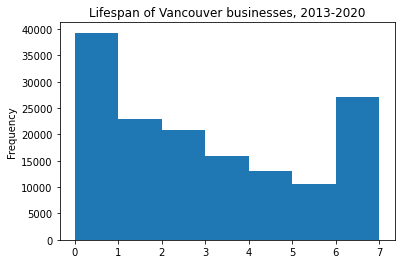

In [32]:
df.groupby('id')['lifespan'].mean().plot.hist(bins=7, title='Lifespan of Vancouver businesses, 2013-2020')

So there we have it, the longer you are in business, the more likely you are to stay in business. Remember that tall bin at 7 years is just everything that is at least 7 years old - that bar is more properly read as *7 or more* years.

And now we have a target variable! Or at least something we can easily make our target from. Now we can work on building our model and standing it up to a public facing portal so anybody interested in starting a business can use our model to see how long a business like theirs is likely to last. It's worth remembering that we've made a lot of assumptions here that are likely to affect our final results. We'll want to make a note of these and anything else we think might be worth experimenting with in the future to improve our model. 

In [33]:
df.shape

(463884, 31)

In [37]:
df.to_csv('../data/2013-2021-clean.csv', index=False)